In [1]:
## load the required packages
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

### Synthetic data generation using specified sets of parameters

In [2]:
# Varied Parameters for simulated data: 
N_sample = 200 #Inputting number of samples 
N_feature = 200 #Inputting number of features
prop_important = 0.3 #Proportion of features that correlate with protection status
prop_redundant = 1-prop_important #Remaining features that are redundant

## Assigning P/N ratio for dataset: Here, there is ~30% of True Negative and ~70% of True Positive
prop_class0 = 0.5  #Proportion of true negatives i.e. Class 0
prop_class1 = 1-prop_class0 #Proportion of true positives i.e. Class 1
wts = [prop_class0,prop_class1] #Assigning weights to reduce sample imbalance based on number of samples in each dataset
## determine class separation for varied difficulties in PU classification task
Class_Sep = 2  ## class separation can range from 0.001, 1, 2... (according to version requirement of sklearn, class_sep = 0 sometimes not available)

# generate synthetic datasets with given dimensions where X is label and y is feature value table
X,Y = make_classification(n_samples= N_sample, 
                          n_features = N_feature, 
                          n_informative= int(prop_important*N_feature),
                          n_redundant= int(prop_redundant*N_feature),
                          weights = wts,
                          n_clusters_per_class = 1,
                          class_sep = Class_Sep,
                          shuffle = True,
                          random_state = 100) # Making dataset, X is label, y is feature value

## extract the index of True Positive instance i.e. label =1
index_TP = np.where(Y==1)[0]

### determine the number of Known Positive instances.
size_P = 40

### simulated P/U label
np.random.seed(2024)  ## set up a seed for the result only for the result to be reproducible
index_P = np.random.choice(index_TP,size = size_P,replace = False) #Choosing indices of subset of points from true positive dataset, to form the positive data set for P/U ML
index_U = np.delete(range(N_sample),index_P,0) #Choosing indices of remaining points (not in positive data set) to form unlabelled dataset

y = np.array(Y) #Data form change
y[index_U] = 0 # Making label of all points in unlabelled dataset as zero

### Transductive P/U Learning adapted from description in Moderlet et al.,2014

In [3]:
## Transductive P/U Learning adapted from description in Moderlet et al.,2014
clf_svm =SVC(C=1, kernel='rbf',class_weight = 'balanced',probability=True,random_state =42) #Defining classifier

#Defining function for transductive pu bagging
def PU_Bagging_transductive(est,X,y,bagging):

    """
    Function Name: add_numbers
    Description: This function output 
    
    Input and hyperparameters:
        -est: choice of ML classifier. In this example, we use SVM-rbf to keep consistent with the work.  
        -X: pandas Dataframe with index as patients' ID
        -y: P/U label - 1 as positive; 0 as unlabeled. 
        -bagging: Number of bootstrap
    
    Return Value:
        A dataframe recording the prediction results for each U set instance from transductive BaggingPU. 
        
    """
    
    index_P = np.where(y==1)[0] #Identifying indices of positive dataset
    index_U = np.where(y==0)[0] #Identifying indices of unlabelled dataset
    Positive_X = X.loc[index_P,:] #Features of positive dataset
    Unlabeled_X = X.loc[index_U,:] #Features in unlabeled dataset
    
    # Create a matrix to calculate ensembled probability.
    count = np.zeros((X.shape[0],3)) 
    count = pd.DataFrame(count,index = X.index)
    
    # define size of bootstrap: match with Number of KP
    size_P = len(index_P) #Identifying no. of datapoints in positive dataset
    size_bag = size_P #Defining size of bag for bootstrap (equal to size of positive dataset)
    
    ## bootstrap aggregation support vector machine under positive unlabeled setting
    # for loop is executed multiple number of times and prediction probability for remaining points (oob) is identified
    for i in range(bagging):
        
        index_bagged = np.random.choice(index_U, size_bag, replace = True) #Identifying points from unlabelled dataset randomly
        index_oob = np.array([index for index in index_U if not index in index_bagged]) #Remaining points belong to oob dataset
        bagged_X = X.loc[index_bagged,:] #Features in bagged dataset (subset of unlabelled dataset)
        oob_X = X.loc[index_oob,:] #Features in oob dataset (subset of unlabelled dataset)
        
        #Defining training set as concatenation of bagged (subset of unlabelled) and positive dataset
        mod_X = pd.concat((Positive_X,bagged_X)) #Training set features 
        mod_y = y[np.append(index_P,index_bagged)] #Training set labels
        est.fit(mod_X,mod_y) # Fitting the classifier based on labels of training dataset
        
        ### Filling probability in a data table
        count.loc[index_oob,0] += est.predict_proba(oob_X)[:,1] #Prediction probability for oob dataset
        count.loc[index_oob,1] += est.predict(oob_X) #Prediction of label for oob dataset
        count.loc[index_oob,2] += 1 #Increasing count by 1
    
    ###Summarizing output of prediction probability for different points across all the repeats (bags)
    count.columns = ["proba_agg","predict_agg","counter"]
    count['proba'] = count['proba_agg']/count['counter']
    count['predict'] = count['predict_agg']/count['counter']    
    return count

### Defining function for spy positive technique to evaluate positive set samples

In [4]:
def SpyPositive_Permutation_Generator(X,y,repetition = 30,permutation = 30, N_folds = 5):
    """
    This is a brief description of what the function does.
    Parameters:
    - X (numpy.ndarray): Matrix 
    - y (numpy.ndarray): P/U Label: 1 as P and 0 as U. 
    - repetition (int): arbitrary number to determine how many times k-fold spy positive split to generate from positive instances under actual label
    - permutation (int): arbitrary number to determine how many permuted labels to generate from actual label. 
    - N_fold (int): fold number to split positive set into spy positive and remaining positive. 
    -
    Returns:
    Two Table in numpy.ndarray to calculate MBS and EPR in each iteration column by column. 
    """
    index_P = np.where(y==1)[0]  #Identifying indices of positive dataset
    index_U = np.where(y==0)[0] #Identifying indices of unlabelled dataset

    val_pool_actual = np.zeros((np.sum(y),repetition)) # Setting up a table to record values across different repeats

    for i in range(repetition): 
        
        print('Actual label iteration: ' + str(i))

        val_list = np.array([]) #Definig an array
        kf = KFold(n_splits= N_folds, shuffle=True) # Create KFold object, ensuring each classes sample labels are shuffled into batches
        fold_ids = list(kf.split(index_P)) # Splitting positive dataset into folds
        
        for fold_id, (remain,spy) in enumerate(fold_ids): 

            index_P_remain = index_P[remain]
            index_P_spy = index_P[spy]
            
            index_U_validation = np.append(index_U, index_P_spy) #Combine unlabelled and spy positive dataset
            size_bag = len(index_P_remain) #Size of bagging dataset is len(positive)-len(spy_positive)
            
            ## "new" y with spy positive combined with U set. 
            y_new = np.zeros(len(y)) #Defining a np for labels
            y_new[index_P_remain] = 1. #Making index of all points in unlabeled plus spy dataset as 1
            count_actual = PU_Bagging_transductive(clf_svm, X , y_new, bagging = 100)
            
            #Executing PU_bagging_transductive function defined earlier
            val_list = np.append(val_list,np.array(count_actual.loc[index_P_spy,'predict'])) #Predicting and storing predicted value for the spy positives
        
        ## record all scores for samples. 
        val_pool_actual[:,i] = val_list #Recording value across all repeats
    
    pd.DataFrame(val_pool_actual).to_csv("validation_pool_actual.csv") #Saving the file in .csv format

    ###Permutation dataset
    val_pool_permuted = np.zeros((np.sum(y),permutation)) #Defining a np for permuted validation pool
    for j in range(permutation): 
        print('Permutation iteration: ' + str(j))
        
        val_list = np.array([]) #Defining an array to hold feature values
        val_index_list = np.array([]) #Defining an array to hold indices
        
        ## for each iteration generated permuted y from actual y.  
        y_permuted = np.random.choice(y,size = len(y),replace = False) #Generating permuted datset
        
        ## Generating index P and index U for permuted dataset 
        index_P = np.where(y_permuted==1)[0] #Identifying indices for positive dataset
        index_U = np.where(y_permuted==0)[0] #Identifying indices for unlabeled dataset
        
        ## Create KFold object
        kf = KFold(n_splits= N_folds, shuffle=True)  #Create KFold object, ensuring each classes sample labels are shuffled into batches
        fold_ids = list(kf.split(index_P)) # Splitting permuted positive dataset into folds
        
        for fold_id, (remain,spy) in enumerate(fold_ids):

            index_P_remain = index_P[remain]
            index_P_spy = index_P[spy]
            
            index_U_validation = np.append(index_U, index_P_spy) #Combine unlabelled and spy positive dataset (permuted)
            size_bag = len(index_P_remain) #Size of bagging dataset is len(positive)-len(spy_positive)
            
            ## permuted y randomly shuffled from y.
            y_permuted = np.zeros(len(y)) #Defining a np for labels
            y_permuted[index_P_remain] = 1. #Making index of all points in unlabeled plus spy dataset as 1
            count_permuted = PU_Bagging_transductive(clf_svm,X,y_permuted, bagging = 100) #Executing PU_bagging_transductive function defined earlier
            val_list = np.append(val_list,np.array(count_permuted.loc[index_P_spy,'predict']))  #Predicting and storing predicted value for the spy positives
        
        ## record all scores for samples. 
        val_pool_permuted[:,j] = val_list #Recording value across all repeats
    
    pd.DataFrame(val_pool_permuted).to_csv("validation_pool_permuted.csv") #Saving the file in .csv format
    
    return val_pool_actual,val_pool_permuted #The function returns values for spy dataset for actual as well as permuted dataset

### Executing the line to generate results for defined value of repeats, permutation and folds

In [5]:
rep_time  = 30 #Number of repeats for actual
perm_time = 30 #Number of repeats for permuted

result = SpyPositive_Permutation_Generator(pd.DataFrame(X),y,
                                           repetition = rep_time,
                                           permutation = perm_time, 
                                           N_folds = 5) ## fold number can be range from 3 to len(index_P)

Actual label iteration: 0
Actual label iteration: 1
Actual label iteration: 2
Actual label iteration: 3
Actual label iteration: 4
Actual label iteration: 5
Actual label iteration: 6
Actual label iteration: 7
Actual label iteration: 8
Actual label iteration: 9
Actual label iteration: 10
Actual label iteration: 11
Actual label iteration: 12
Actual label iteration: 13
Actual label iteration: 14
Actual label iteration: 15
Actual label iteration: 16
Actual label iteration: 17
Actual label iteration: 18
Actual label iteration: 19
Actual label iteration: 20
Actual label iteration: 21
Actual label iteration: 22
Actual label iteration: 23
Actual label iteration: 24
Actual label iteration: 25
Actual label iteration: 26
Actual label iteration: 27
Actual label iteration: 28
Actual label iteration: 29
Permutation iteration: 0
Permutation iteration: 1
Permutation iteration: 2
Permutation iteration: 3
Permutation iteration: 4
Permutation iteration: 5
Permutation iteration: 6
Permutation iteration: 7


### Calculating and Visualizing the results under specified parameter setting

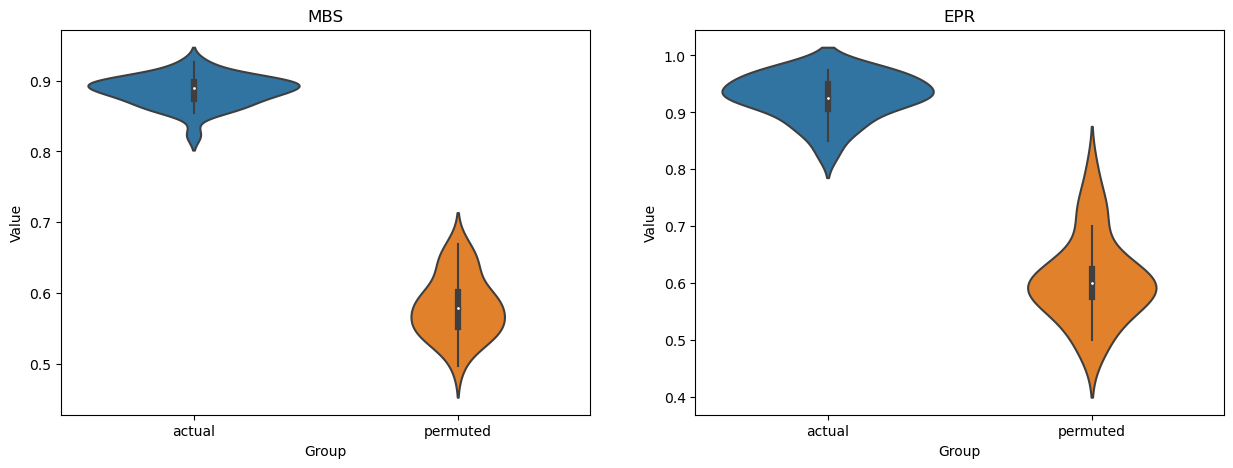

In [6]:
#Plotting results using matlab
import matplotlib.pyplot as plt #Importing package
import seaborn as sns #Importing package
permuted_mat = pd.read_csv('validation_pool_permuted.csv',index_col = 0) #Reading the saved file for permuted dataset
actual_mat = pd.read_csv('validation_pool_actual.csv',index_col = 0) #Reading the saved file for actual dataset

MBS_actual = actual_mat.mean(axis = 0) #Calculating mean bagging score for actual dataset
MBS_permuted = permuted_mat.mean(axis = 0) #Calculating mean bagging score for permuted dataset

#Defining empty datasets to calculate explicit precision recall (scored prediction quality by calculating the proportion of known positive samples that were predicted positive) 
EPR_actual = []
EPR_permuted = []
for i in range(rep_time):
    EPR_actual.append((actual_mat.iloc[:,i] > 0.5).sum()/len(index_P))
    EPR_permuted.append((permuted_mat.iloc[:,i] > 0.5).sum()/len(index_P))

#Defining a dataframe to draw boxplots for MBS and EPR
boxplot_df = pd.DataFrame({'Method':['MBS']* (rep_time + perm_time) + ['EPR']* (rep_time + perm_time),
                           'Group':['actual']* rep_time + ['permuted']* perm_time + ['actual']* rep_time + ['permuted']*perm_time,
                           'Value': list(MBS_actual) + list(MBS_permuted)+list(EPR_actual)+list(EPR_permuted)})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5)) #Defining characteristics for generating a figue

# Generating violin plot with box plots (as inset) by looping through the dataframes
for i, category in enumerate(boxplot_df['Method'].unique()):
    sns.violinplot(x='Group', y='Value', data=boxplot_df[boxplot_df['Method']==category], ax=axes[i])
    axes[i].set_title(f'{category}')
plt.show()